# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-04-29 20:14:48.596041: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 20:14:48.693649: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 20:14:48.694494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 20:14:49.967957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 1s 0us/step


2023-04-29 20:16:56.949513: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


In [39]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.sigmoid(y)
        #return tf.nn.tanh(y)
        #return tf.nn.relu(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_3(x)
    return tf.nn.softmax(x)

In [40]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [41]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [42]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):

    train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)

        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss.numpy())

        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)

        print(f"step: {step}, loss: {loss}, accuracy: {acc}")

2023-04-29 21:37:24.521563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,784]
	 [[{{node Placeholder/_0}}]]
2023-04-29 21:37:24.522327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]


step: 0, loss: 625.6193237304688, accuracy: 0.11328125
step: 100, loss: 592.7291259765625, accuracy: 0.0703125
step: 200, loss: 555.6027221679688, accuracy: 0.11328125
step: 300, loss: 551.1636962890625, accuracy: 0.11328125
step: 400, loss: 530.8931884765625, accuracy: 0.171875
step: 500, loss: 524.8746337890625, accuracy: 0.296875
step: 600, loss: 498.7004089355469, accuracy: 0.51171875
step: 700, loss: 491.609619140625, accuracy: 0.53515625
step: 800, loss: 480.0041809082031, accuracy: 0.58203125
step: 900, loss: 490.8282470703125, accuracy: 0.5078125
step: 1000, loss: 475.2070007324219, accuracy: 0.6015625
step: 1100, loss: 473.1112365722656, accuracy: 0.58984375
step: 1200, loss: 465.04254150390625, accuracy: 0.65234375
step: 1300, loss: 457.99078369140625, accuracy: 0.68359375
step: 1400, loss: 445.43231201171875, accuracy: 0.70703125
step: 1500, loss: 442.1985778808594, accuracy: 0.72265625
step: 1600, loss: 448.5472106933594, accuracy: 0.70703125
step: 1700, loss: 443.134155273

Text(0.5, 0.98, 'График зависимости изменения точности и потерь от шага')

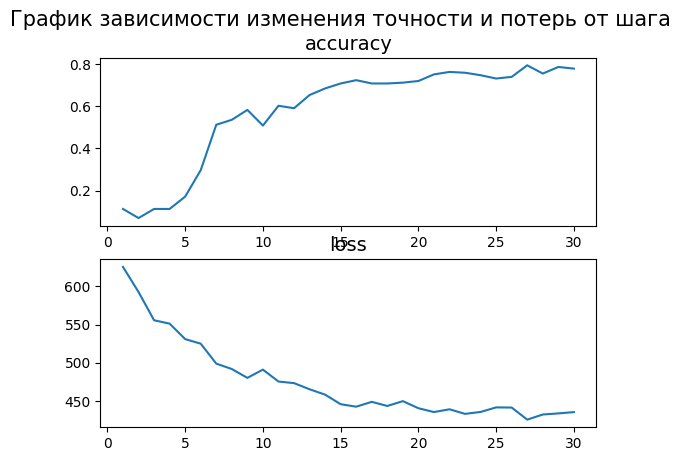

In [65]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(step, accuracy_history, label='accuracy')
axs[0].set_title('accuracy', fontsize=14)

axs[1].plot(step, loss_history, label='loss')
axs[1].set_title('loss', fontsize=14)

fig.suptitle('График зависимости изменения точности и потерь от шага', fontsize=15)

In [60]:
model = neural_net(x_test)
print(f"Accuracy = {accuracy(model, y_test).numpy()}")

Accuracy = 0.7635999917984009


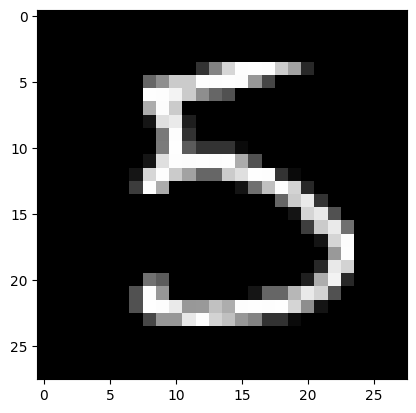

Answer = 3


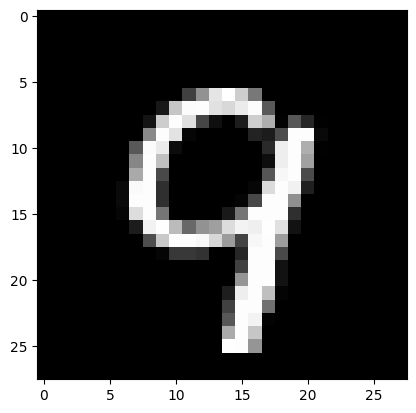

Answer = 9


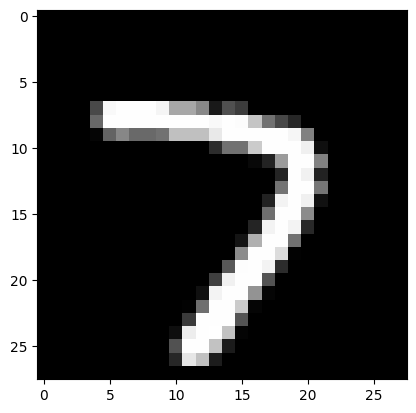

Answer = 7


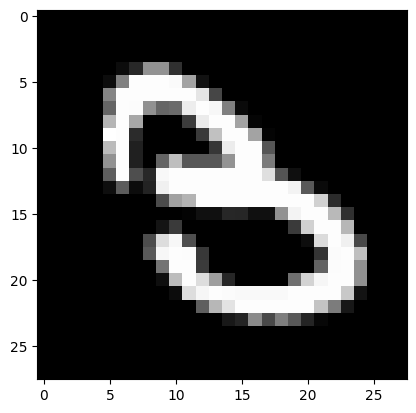

Answer = 3


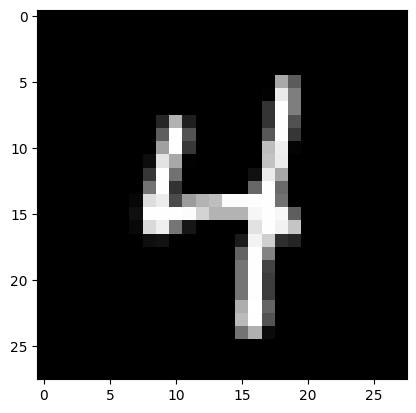

Answer = 4


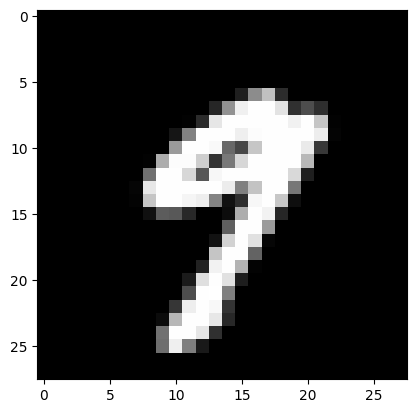

Answer = 9


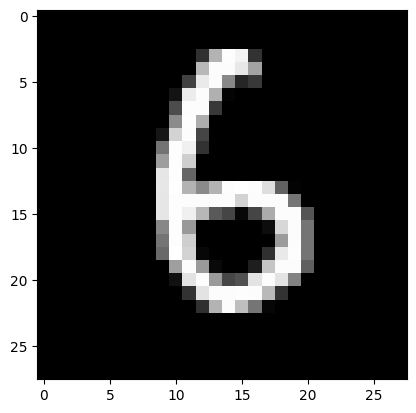

Answer = 6


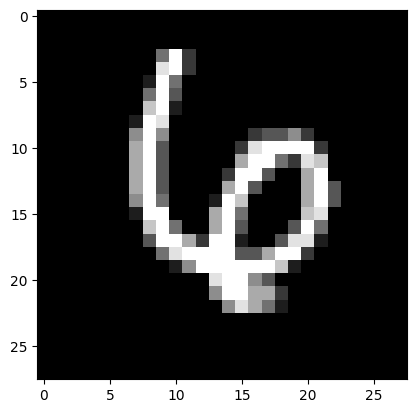

Answer = 6


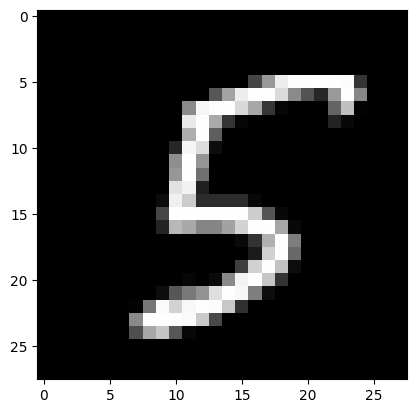

Answer = 6


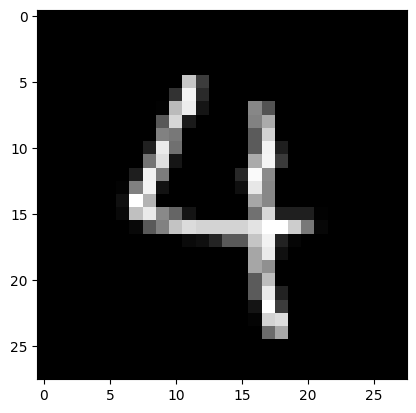

Answer = 4
Predicted label: [3 9 7 3 4 9 6 6 6 4]
True labels: [5 9 7 3 4 9 6 6 5 4]


In [79]:
images = x_test[15:25]
model = neural_net(images)

for i in range(10):
    plt.imshow(np.reshape(images[i],[28,28]),cmap='gray')
    plt.show()

    print(f'Answer = {np.argmax(model.numpy()[i])}')

print(f'Predicted label: {np.argmax(model, axis = 1)}')
print(f'True labels: {y_test[15:25]}')